# Exotic Options

We will be using a Monte Carlo Simulation for all valuations. We need to generate price paths.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
rng = np.random.default_rng(seed = 1000)

In [2]:
def random_walk(S0: float, 
                T: float,
                sigma: float,
                r: float,
                N: int,
                n_sims: int):
    
    # Define length of time steps
    dt = T/N

    # Calculate an array of price paths using GBM

    paths = S0 * np.exp(np.cumsum((r - sigma**2/2)*dt + \
                                          sigma*np.sqrt(dt) * \
                                            rng.normal(size  = [N, n_sims]), axis = 0))
    

    return paths

## Binary (Digital) Options

S0: float       - The initial stock price\
T: float        - The time to maturity of the option (in years)\
sigma: float    - The volatility of the underlying asset (standard deviation of the asset's log returns)\
r: float        - The risk-free interest rate (annualized)\
N: int          - The total number of time steps in the simulation\
n_sims: int     - The number of simulated paths\
K: float        - The strike price of the binary put option\
P: float        - The payout of the binary put option if it expires in-the-money

### Binary Calls

In [3]:
def dig_call(S0: float, T: float, sigma: float, r: float, N: int, n_sims: int, K: float, P: float):

    paths = random_walk(S0,
                        T,
                        sigma,
                        r,
                        N,
                        n_sims)

    payoffs = P * (paths[-1] > K) # Check that the terminal price is above the strike price, returning 1 if above

    price = np.mean(payoffs)*np.exp(-r*T)

    # Calculate probabilities
    prob_in_the_money = np.mean(paths[-1] > K)
    prob_out_of_the_money = 1 - prob_in_the_money

    # Print probabilities
    print(f"Expected Price of the Binary Call Option: ${price:.4f}")
    print(f"Probability of being in-the-money: {prob_in_the_money*100:.4f}%")
    print(f"Probability of being out-of-the-money: {prob_out_of_the_money*100:.4f}%")

    plt.figure(figsize=(10, 6))
    plt.plot(paths[-1], payoffs, 'ro') # Plotting the final asset prices vs the binary payoffs
    plt.axhline(y=P, color='g', linestyle='--') # Line for P payoff
    plt.axhline(y=0, color='b', linestyle='--') # Line for 0 payoff
    plt.axvline(x=K, color='k', linestyle='--') # Line for strike price K
    plt.xlabel('Final Asset Price')
    plt.ylabel('Payoff')
    plt.title('Binary Call Option Payoff at Expiry')
    plt.grid(True)
    plt.show()

    return price

Expected Price of the Binary Call Option: $1.7348
Probability of being in-the-money: 36.4740%
Probability of being out-of-the-money: 63.5260%


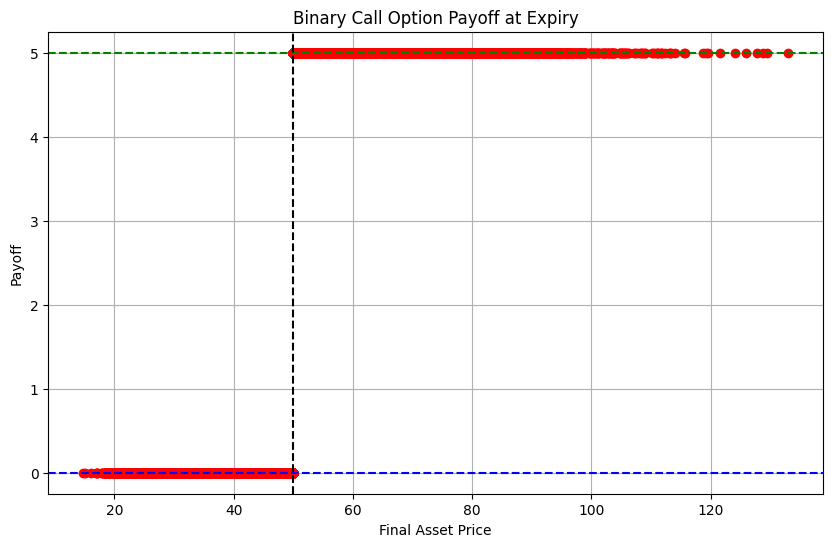

1.7347571014619523

In [4]:
dig_call(S0 = 45,
         T = 1,
         sigma = 0.25,
         r=0.05,
         N = 252,
         n_sims = 100_000,
         K= 50,
         P = 5)

### Binary Puts

In [5]:
def dig_put(S0: float, T: float, sigma: float, r: float, N: int, n_sims: int, K: float, P: float):

    paths = random_walk(S0,
                        T,
                        sigma,
                        r,
                        N,
                        n_sims)

    payoffs = P * (paths[-1] < K) # Check that the terminal price is above the strike price, returning 1 if above

    price = np.mean(payoffs)*np.exp(-r*T)

    # Calculate probabilities
    prob_in_the_money = np.mean(paths[-1] < K)
    prob_out_of_the_money = 1 - prob_in_the_money

    # Print probabilities
    print(f"Expected Price of the Binary Put Option: ${price:.4f}")
    print(f"Probability of being in-the-money: {prob_in_the_money*100:.4f}%")
    print(f"Probability of being out-of-the-money: {prob_out_of_the_money*100:.4f}%")

    plt.figure(figsize=(10, 6))
    plt.plot(paths[-1], payoffs, 'ro') # Plotting the final asset prices vs the binary payoffs
    plt.axhline(y=P, color='g', linestyle='--') # Line for P payoff
    plt.axhline(y=0, color='b', linestyle='--') # Line for 0 payoff
    plt.axvline(x=K, color='k', linestyle='--') # Line for strike price K
    plt.xlabel('Final Asset Price')
    plt.ylabel('Payoff')
    plt.title('Binary Put Option Payoff at Expiry')
    plt.grid(True)
    plt.show()

    return price

Expected Price of the Binary Put Option: $3.0201
Probability of being in-the-money: 63.4980%
Probability of being out-of-the-money: 36.5020%


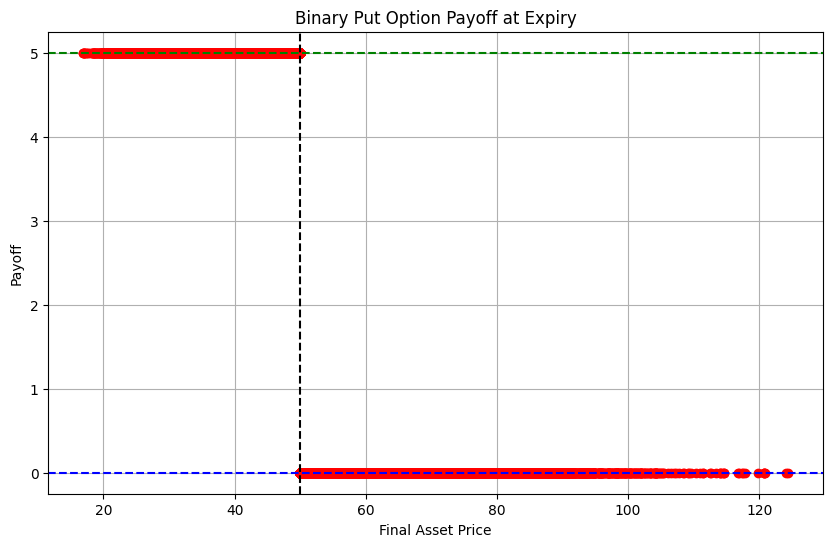

3.020058299847317

In [6]:
dig_put(S0 = 45,
         T = 1,
         sigma = 0.25,
         r=0.05,
         N = 252,
         n_sims = 100_000,
         K= 50,
         P = 5)

## Barrier Options

S0: float       - The initial stock price\
T: float        - The time to maturity of the option (in years)\
sigma: float    - The volatility of the underlying asset (standard deviation of the asset's log returns)\
r: float        - The risk-free interest rate (annualized)\
N: int          - The total number of time steps in the simulation\
n_sims: int     - The number of simulated paths\
K: float        - The strike price of the binary put option\
B: float        - The barrier level. If the asset price exceeds/falls this level at any time before expiration, the option becomes worthless.

## Up-and-In Call Option

### This option only comes into existence if the underlying asset's price goes up and touches or exceeds a specified barrier level during the life of the option.
### Payoff: If the underlying price crosses the barrier, the option behaves like a regular call option, otherwise worthless

In [7]:
def up_in_call(S0: float, 
               T: float,
               sigma: float,
               r: float,
               N: int,
               n_sims: int,
               K: float,
               B: float):

    paths = random_walk(S0,
                        T,
                        sigma,
                        r,
                        N,
                        n_sims)
    
    barrier = (np.max(paths, axis = 0) >= B) * 1 

    payoffs = np.maximum(paths[-1] - K, 0) * barrier 

    prob_in_the_money = np.mean((paths[-1] > K) & (np.max(paths, axis=0) >= B))
    prob_out_of_the_money = 1 - prob_in_the_money
    prob_active = np.mean(np.max(paths, axis=0) >= B)
    prob_not_active = 1 - prob_active

    price = np.mean(payoffs) * np.exp(-r * T)

    print(f"Expected Price of the Up-and-In Call Option: ${price:.4f}")
    print(f"Probability of being in-the-money: {prob_in_the_money*100:.4f}%")
    print(f"Probability of being out-of-the-money: {prob_out_of_the_money*100:.4f}%")
    print(f"Probability of being active: {prob_active*100:.4f}%")
    print(f"Probability of not being active: {prob_not_active*100:.4f}%")

    plt.figure(figsize=(10, 6))
    active_options = barrier == 1  
    plt.plot(paths[-1][active_options], payoffs[active_options], 'go', label='Knocked-In Options', markersize=5) 
    inactive_options = paths[-1][~active_options]
    plt.plot(inactive_options, np.zeros_like(inactive_options), 'ro', label='Not Knocked-In Options', markersize=5)  
    
    final_prices = np.linspace(paths[-1].min(), paths[-1].max(), num=500)
    theoretical_payoffs = np.maximum(final_prices - K, 0) * (final_prices >= B)  
    plt.plot(final_prices, theoretical_payoffs, 'b-', label='Theoretical Payoff', linewidth=2)  

    plt.axvline(x=K, color='gray', linestyle='--', label='Strike Price') 
    plt.axvline(x=B, color='black', linestyle='--', label='Barrier')  
    plt.xlabel('Final Asset Price')
    plt.ylabel('Payoff')
    plt.title('Up-and-In Call Option Payoff at Expiry')
    plt.legend()
    plt.grid(True)
    plt.show()

    return price

Expected Price of the Up-and-In Call Option: $0.1162
Probability of being in-the-money: 1.0820%
Probability of being out-of-the-money: 98.9180%
Probability of being active: 1.0900%
Probability of not being active: 98.9100%


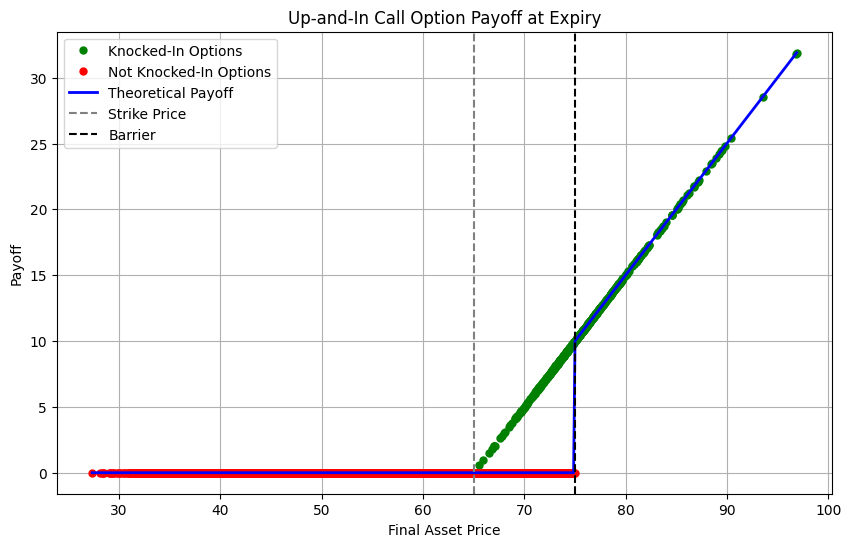

0.11623193346626992

In [8]:
up_in_call(S0 = 50,
            T = 1,
            sigma = 0.15,
            r = 0.04,
            N = 252,
            n_sims = 50_000,
            K = 65,
            B = 75)

## Up-and-In Put Option

### This option comes into existence if the underlying asset's price moves up and touches or exceeds the barrier during the life of the option.

### Once activated, the option behaves like a regular put option, otherwise worthless

In [9]:
def up_in_put(S0: float, 
              T: float,
              sigma: float,
              r: float,
              N: int,
              n_sims: int,
              K: float,
              B: float):

    paths = random_walk(S0,
                        T,
                        sigma,
                        r,
                        N,
                        n_sims)
    
    barrier = (np.max(paths, axis = 0) >= B) * 1 

    payoffs = np.maximum(K - paths[-1], 0) * barrier 

    prob_in_the_money = np.mean((paths[-1] < K) & (np.max(paths, axis=0) >= B))
    prob_out_of_the_money = 1 - prob_in_the_money
    prob_active = np.mean(np.max(paths, axis=0) >= B)
    prob_not_active = 1 - prob_active

    price = np.mean(payoffs) * np.exp(-r * T)

    print(f"Expected Price of the Up-and-In Put Option: ${price:.4f}")
    print(f"Probability of being in-the-money: {prob_in_the_money*100:.4f}%")
    print(f"Probability of being out-of-the-money: {prob_out_of_the_money*100:.4f}%")
    print(f"Probability of being active: {prob_active*100:.4f}%")
    print(f"Probability of not being active: {prob_not_active*100:.4f}%")

    plt.figure(figsize=(10, 6))
    knocked_in_options = barrier == 1 
    plt.plot(paths[-1][knocked_in_options], payoffs[knocked_in_options], 'go', label='Knocked-In Options', markersize=5) 
    not_knocked_in_options = paths[-1][~knocked_in_options]
    plt.plot(not_knocked_in_options, np.zeros_like(not_knocked_in_options), 'ro', label='Not Knocked-In Options', markersize=5)  
    
    final_prices = np.linspace(paths[-1].min(), paths[-1].max(), num=500)
    theoretical_payoffs = np.maximum(K - final_prices, 0) * (final_prices >= B)  
    plt.plot(final_prices, theoretical_payoffs, 'b-', label='Theoretical Payoff', linewidth=2)  
    """
    final_prices = np.linspace(paths[-1].min(), paths[-1].max(), num=500)
    theoretical_payoffs = np.maximum(K - final_prices, 0) * (final_prices >= B)  
    plt.plot(final_prices, theoretical_payoffs, 'b-', label='Theoretical Payoff', linewidth=2)
    """
    plt.axvline(x=K, color='gray', linestyle='--', label='Strike Price') 
    plt.axvline(x=B, color='black', linestyle='--', label='Barrier')  
    plt.xlabel('Final Asset Price')
    plt.ylabel('Payoff')
    plt.title('Up-and-In Put Option Payoff at Expiry')
    plt.legend()
    plt.grid(True)
    plt.show()

    return price

Expected Price of the Up-and-In Put Option: $7.3733
Probability of being in-the-money: 58.8640%
Probability of being out-of-the-money: 41.1360%
Probability of being active: 100.0000%
Probability of not being active: 0.0000%


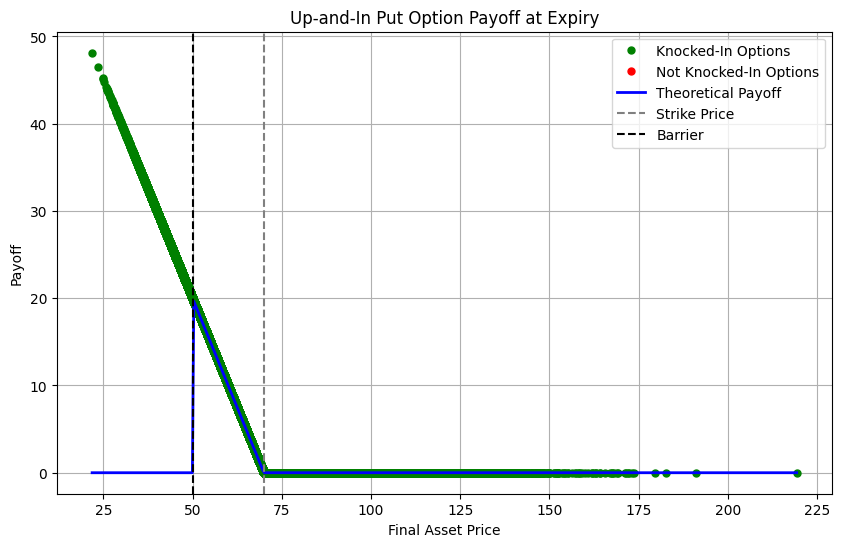

7.373277800883567

In [10]:
up_in_put(S0 = 65,
            T = 1,
            sigma = 0.25,
            r = 0.05,
            N = 252,
            n_sims = 100_000,
            K = 70,
            B = 50)

## Up-and-Out Call Option

### This call option is active until the price of the underlying asset moves up and touches or exceeds the barrier level. Once the barrier is breached, the option immediately expires.

### Payoff: If the barrier is not touched, the option behaves like a regular call option, otherwise if barrier hit the option is immediately void and expires worthless

In [11]:
def up_out_call(S0: float, 
                T: float,
                sigma: float,
                r: float,
                N: int,
                n_sims: int,
                K: float,
                B: float):

    paths = random_walk(S0,
                        T,
                        sigma,
                        r,
                        N,
                        n_sims)
    
    barrier = (np.max(paths, axis = 0) < B) * 1 

    payoffs = np.maximum(paths[-1] - K, 0) * barrier 

    prob_in_the_money = np.mean((paths[-1] > K) & (np.max(paths, axis=0) < B))
    prob_out_of_the_money = 1 - prob_in_the_money
    prob_knocked_out = 1 - np.mean(np.max(paths, axis=0) < B)
    prob_not_knocked_out = 1 - prob_knocked_out

    price = np.mean(payoffs) * np.exp(-r * T)

    print(f"Expected Price of the Up-and-Out Call Option: ${price:.4f}")
    print(f"Probability of being in-the-money: {prob_in_the_money*100:.4f}%")
    print(f"Probability of being out-of-the-money: {prob_out_of_the_money*100:.4f}%")
    print(f"Probability of being knocked out: {prob_knocked_out*100:.4f}%")
    print(f"Probability of not being knocked out: {prob_not_knocked_out*100:.4f}%")

    plt.figure(figsize=(10, 6))
    active_options = barrier == 1  
    plt.plot(paths[-1][active_options], payoffs[active_options], 'go', label='Active Options', markersize=5) 
    knocked_out_options = paths[-1][~active_options]
    plt.plot(knocked_out_options, np.zeros_like(knocked_out_options), 'ro', label='Knocked-Out Options', markersize=5)  

    final_prices = np.linspace(paths[-1].min(), paths[-1].max(), num=500)
    theoretical_payoffs = np.maximum(final_prices - K, 0) * (final_prices < B)  
    plt.plot(final_prices, theoretical_payoffs, 'b-', label='Theoretical Payoff', linewidth=2)  

    plt.axvline(x=K, color='gray', linestyle='--', label='Strike Price') 
    plt.axvline(x=B, color='black', linestyle='--', label='Barrier')  
    plt.xlabel('Final Asset Price')
    plt.ylabel('Payoff')
    plt.title('Up-and-Out Call Option Payoff at Expiry')
    plt.legend()
    plt.grid(True)
    plt.show()

    return price

Expected Price of the Up-and-Out Call Option: $2.3456
Probability of being in-the-money: 32.1860%
Probability of being out-of-the-money: 67.8140%
Probability of being knocked out: 4.4230%
Probability of not being knocked out: 95.5770%


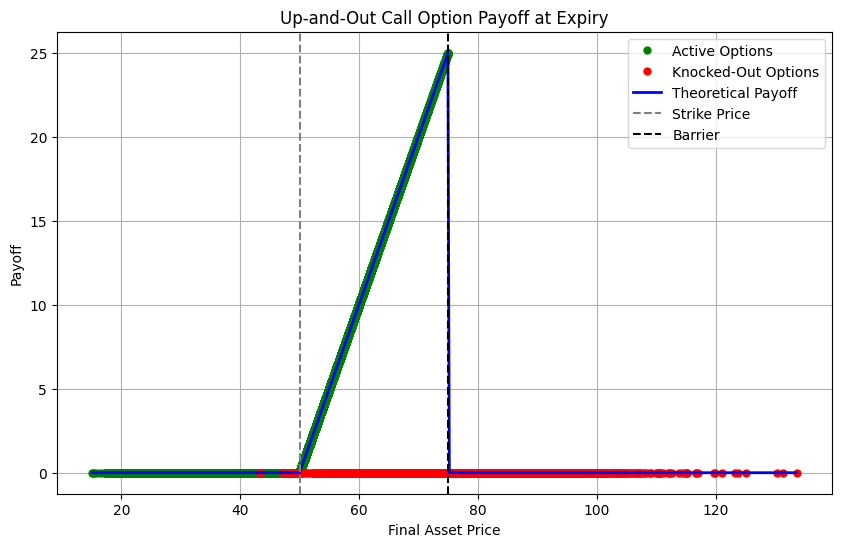

2.3456403672916455

In [12]:
up_out_call(S0 = 45,
            T = 1,
            sigma = 0.25,
            r = 0.05,
            N = 252,
            n_sims = 100_000,
            K = 50,
            B = 75)

## Up-and-Out Put Option

### This put option remains valid unless the price of the underlying asset moves up and touches or exceeds the barrier level. If the barrier is breached, the option is immediately knocked out.

### Payoff: If the barrier is not breached, the option acts as a regular put option, otherwise if barrier hit the option is immediately void and expires worthless

In [13]:
def up_out_put(S0: float, 
               T: float,
               sigma: float,
               r: float,
               N: int,
               n_sims: int,
               K: float,
               B: float):

    paths = random_walk(S0,
                        T,
                        sigma,
                        r,
                        N,
                        n_sims)
    
    barrier = (np.max(paths, axis = 0) < B) * 1 

    payoffs = np.maximum(K - paths[-1], 0) * barrier 

    prob_in_the_money = np.mean((paths[-1] < K) & (np.max(paths, axis=0) < B))
    prob_out_of_the_money = 1 - prob_in_the_money
    prob_knocked_out = 1 - np.mean(np.max(paths, axis=0) < B)
    prob_not_knocked_out = 1 - prob_knocked_out

    price = np.mean(payoffs) * np.exp(-r * T)

    print(f"Expected Price of the Up-and-Out Put Option: ${price:.4f}")
    print(f"Probability of being in-the-money: {prob_in_the_money*100:.4f}%")
    print(f"Probability of being out-of-the-money: {prob_out_of_the_money*100:.4f}%")
    print(f"Probability of being knocked out: {prob_knocked_out*100:.4f}%")
    print(f"Probability of not being knocked out: {prob_not_knocked_out*100:.4f}%")

    plt.figure(figsize=(10, 6))
    active_options = barrier == 1  
    plt.plot(paths[-1][active_options], payoffs[active_options], 'go', label='Active Options', markersize=5) 
    knocked_out_options = paths[-1][~active_options]
    plt.plot(knocked_out_options, np.zeros_like(knocked_out_options), 'ro', label='Knocked-Out Options', markersize=5)  
    
    final_prices = np.linspace(paths[-1].min(), paths[-1].max(), num=500)
    theoretical_payoffs = np.maximum(K - final_prices, 0) * (final_prices < B)
    plt.plot(final_prices, theoretical_payoffs, 'b-', label='Theoretical Payoff', linewidth=2)

    plt.axvline(x=K, color='gray', linestyle='--', label='Strike Price') 
    plt.axvline(x=B, color='black', linestyle='--', label='Barrier')  
    plt.xlabel('Final Asset Price')
    plt.ylabel('Payoff')
    plt.title('Up-and-Out Put Option Payoff at Expiry')
    plt.legend()
    plt.grid(True)
    plt.show()

    return price

Expected Price of the Up-and-Out Put Option: $0.0000
Probability of being in-the-money: 0.0000%
Probability of being out-of-the-money: 100.0000%
Probability of being knocked out: 100.0000%
Probability of not being knocked out: 0.0000%


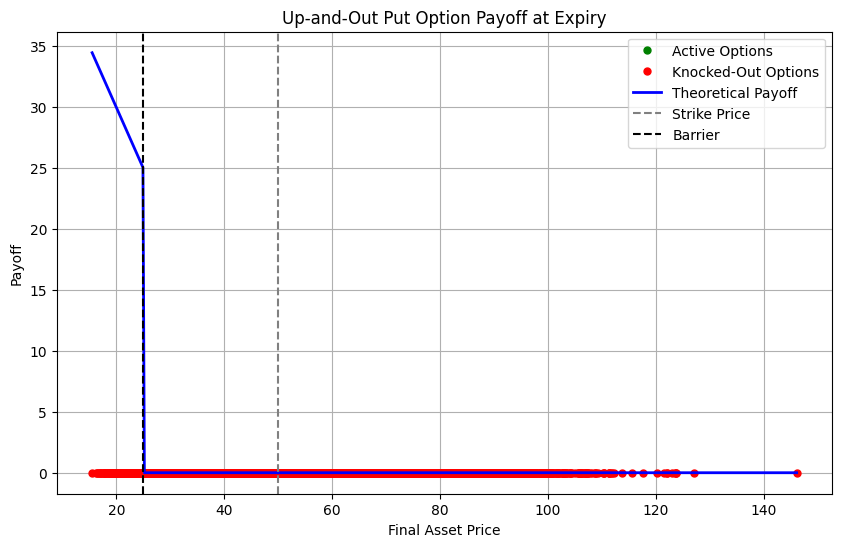

0.0

In [14]:
up_out_put(S0 = 45,
            T = 1,
            sigma = 0.25,
            r = 0.05,
            N = 252,
            n_sims = 100_000,
            K = 50,
            B = 25)

## Down-and-In Call Option

### This call option comes into existence only if the underlying asset’s price goes down and touches or falls below the barrier level during the life of the option.

### Once activated, the option behaves like a regular call option, otherwise expires worthless

In [15]:
def down_in_call(S0: float, 
                 T: float,
                 sigma: float,
                 r: float,
                 N: int,
                 n_sims: int,
                 K: float,
                 B: float):

    paths = random_walk(S0,
                        T,
                        sigma,
                        r,
                        N,
                        n_sims)
    
    barrier = (np.min(paths, axis=0) <= B) * 1  

    payoffs = np.maximum(paths[-1] - K, 0) * barrier 

    prob_in_the_money = np.mean((paths[-1] > K) & (np.min(paths, axis=0) <= B)) 
    prob_out_of_the_money = 1 - prob_in_the_money
    prob_knocked_in = np.mean(np.min(paths, axis=0) <= B)
    prob_not_knocked_in = 1 - prob_knocked_in

    price = np.mean(payoffs) * np.exp(-r * T)

    print(f"Expected Price of the Down-and-In Call Option: ${price:.4f}")
    print(f"Probability of being in-the-money: {prob_in_the_money*100:.4f}%")
    print(f"Probability of being out-of-the-money: {prob_out_of_the_money*100:.4f}%")
    print(f"Probability of being knocked in: {prob_knocked_in*100:.4f}%")
    print(f"Probability of not being knocked in: {prob_not_knocked_in*100:.4f}%")

    plt.figure(figsize=(10, 6))
    knocked_in_options = barrier == 1 
    plt.plot(paths[-1][knocked_in_options], payoffs[knocked_in_options], 'go', label='Knocked-In Options', markersize=5)  
    not_knocked_in_options = paths[-1][~knocked_in_options]
    plt.plot(not_knocked_in_options, np.zeros_like(not_knocked_in_options), 'ro', label='Not Knocked-In Options', markersize=5)  
    plt.axvline(x=K, color='gray', linestyle='--', label='Strike Price') 
    plt.axvline(x=B, color='black', linestyle='--', label='Barrier')  

    final_prices = np.linspace(paths[-1].min(), paths[-1].max(), num=500)
    theoretical_payoffs = np.maximum(final_prices - K, 0) * (np.min(final_prices) <= B)
    plt.plot(final_prices, theoretical_payoffs, 'b-', label='Theoretical Payoff', linewidth=2)  
    
    plt.xlabel('Final Asset Price')
    plt.ylabel('Payoff')
    plt.title('Down-and-In Call Option Payoff at Expiry')
    plt.legend()
    plt.grid(True)
    plt.show()

    return price

Expected Price of the Down-and-In Call Option: $1.0336
Probability of being in-the-money: 12.5510%
Probability of being out-of-the-money: 87.4490%
Probability of being knocked in: 65.5220%
Probability of not being knocked in: 34.4780%


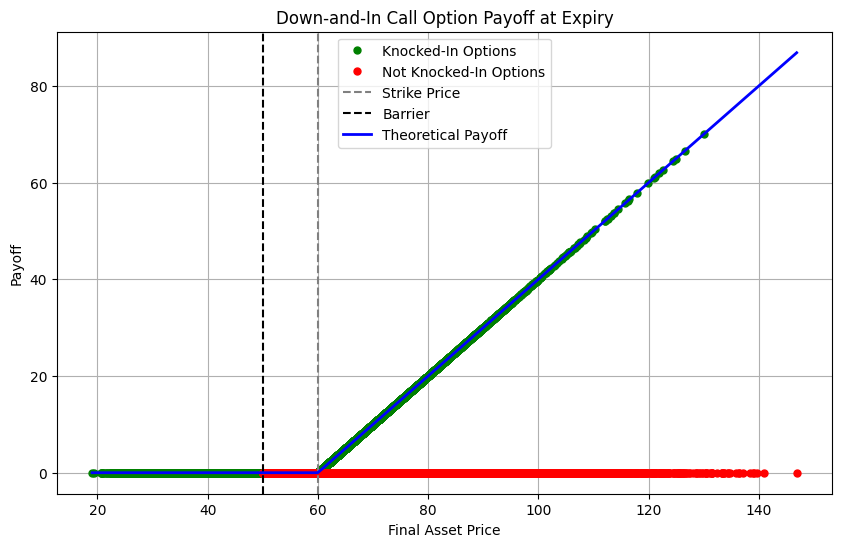

1.0336130460542325

In [16]:
down_in_call(S0 = 55,
            T = 1,
            sigma = 0.25,
            r = 0.05,
            N = 252,
            n_sims = 100_000,
            K = 60,
            B = 50)

## Down-and-In Put Option

### This put option becomes active if the underlying price falls down and touches or falls below the barrier level during the life of the option.

### Once the barrier is crossed, the option becomes a regular put option, otherwise the option expires worthless

In [17]:
def down_in_put(S0: float, 
                T: float,
                sigma: float,
                r: float,
                N: int,
                n_sims: int,
                K: float,
                B: float):

    paths = random_walk(S0,
                        T,
                        sigma,
                        r,
                        N,
                        n_sims)
    
    barrier = (np.min(paths, axis=0) <= B) * 1 

    payoffs = np.maximum(K - paths[-1], 0) * barrier 

    prob_in_the_money = np.mean((paths[-1] < K) & (np.min(paths, axis=0) <= B)) 
    prob_out_of_the_money = 1 - prob_in_the_money
    prob_knocked_in = np.mean(np.min(paths, axis=0) <= B)
    prob_not_knocked_in = 1 - prob_knocked_in

    price = np.mean(payoffs) * np.exp(-r * T)

    print(f"Expected Price of the Down-and-In Put Option: ${price:.4f}")
    print(f"Probability of being in-the-money: {prob_in_the_money*100:.4f}%")
    print(f"Probability of being out-of-the-money: {prob_out_of_the_money*100:.4f}%")
    print(f"Probability of being knocked in: {prob_knocked_in*100:.4f}%")
    print(f"Probability of not being knocked in: {prob_not_knocked_in*100:.4f}%")

    plt.figure(figsize=(10, 6))
    knocked_in_options = barrier == 1 
    plt.plot(paths[-1][knocked_in_options], payoffs[knocked_in_options], 'go', label='Knocked-In Options', markersize=5)  
    not_knocked_in_options = paths[-1][~knocked_in_options]
    plt.plot(not_knocked_in_options, np.zeros_like(not_knocked_in_options), 'ro', label='Not Knocked-In Options', markersize=5)  
    plt.axvline(x=K, color='gray', linestyle='--', label='Strike Price') 
    plt.axvline(x=B, color='black', linestyle='--', label='Barrier')  

    final_prices = np.linspace(paths[-1].min(), paths[-1].max(), num=500)
    theoretical_payoffs = np.maximum(K - final_prices, 0) * (final_prices <= B)  
    plt.plot(final_prices, theoretical_payoffs, 'b-', label='Theoretical Payoff', linewidth=2)
   
    plt.xlabel('Final Asset Price')
    plt.ylabel('Payoff')
    plt.title('Down-and-In Put Option Payoff at Expiry')
    plt.legend()
    plt.grid(True)
    plt.show()

    return price

Expected Price of the Down-and-In Put Option: $3.7723
Probability of being in-the-money: 26.5800%
Probability of being out-of-the-money: 73.4200%
Probability of being knocked in: 27.2440%
Probability of not being knocked in: 72.7560%


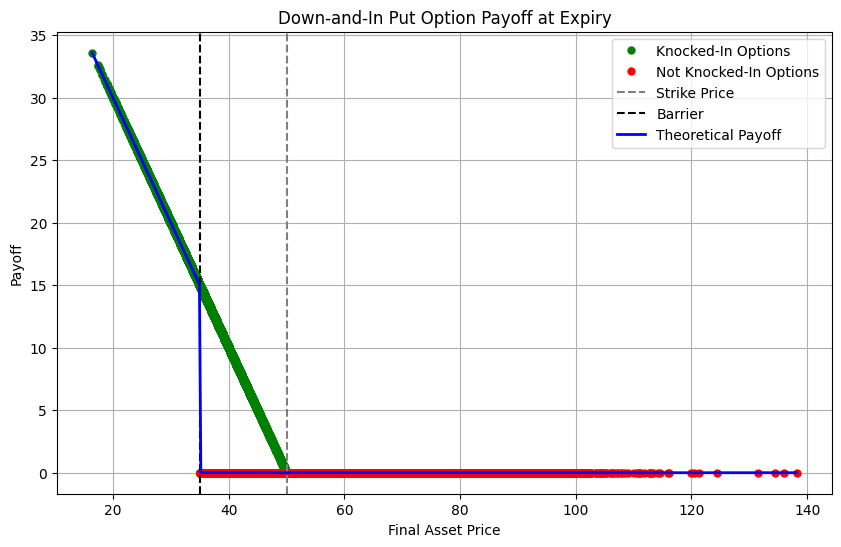

3.772262371810482

In [18]:
down_in_put(S0 = 45,
            T = 1,
            sigma = 0.25,
            r = 0.05,
            N = 252,
            n_sims = 100_000,
            K = 50,
            B = 35)

## Down-and-Out Call Option

### This call option stays in force unless the price of the underlying asset moves down and touches or falls below the barrier level. Once the barrier is breached, the option knocks out.

In [19]:
def down_out_call(S0: float, 
                 T: float,
                 sigma: float,
                 r: float,
                 N: int,
                 n_sims: int,
                 K: float,
                 B: float):

    paths = random_walk(S0,
                        T,
                        sigma,
                        r,
                        N,
                        n_sims)
    
    barrier = (np.min(paths, axis=0) > B) * 1  

    payoffs = np.maximum(paths[-1] - K, 0) * barrier 

    prob_in_the_money = np.mean((paths[-1] > K) & (np.min(paths, axis=0) > B)) 
    prob_out_of_the_money = 1 - prob_in_the_money
    prob_knocked_out = 1 - np.mean(np.min(paths, axis=0) > B)
    prob_not_knocked_out = 1 - prob_knocked_out

    price = np.mean(payoffs) * np.exp(-r * T)

    print(f"Expected Price of the Down-and-Out Call Option: ${price:.4f}")
    print(f"Probability of being in-the-money: {prob_in_the_money*100:.4f}%")
    print(f"Probability of being out-of-the-money: {prob_out_of_the_money*100:.4f}%")
    print(f"Probability of being knocked out: {prob_knocked_out*100:.4f}%")
    print(f"Probability of not being knocked out: {prob_not_knocked_out*100:.4f}%")

    plt.figure(figsize=(10, 6))
    not_knocked_out_options = barrier == 1 
    plt.plot(paths[-1][not_knocked_out_options], payoffs[not_knocked_out_options], 'go', label='Not Knocked-Out Options') 
    knocked_out_options = paths[-1][~not_knocked_out_options]
    plt.plot(knocked_out_options, np.zeros_like(knocked_out_options), 'ro', label='Knocked-Out Options') 
    plt.axvline(x=K, color='gray', linestyle='--', label='Strike Price') 
    plt.axvline(x=B, color='black', linestyle='--', label='Barrier') 

    final_prices = np.linspace(paths[-1].min(), paths[-1].max(), num=500)
    theoretical_payoffs = np.maximum(final_prices - K, 0) * (B < final_prices)  
    plt.plot(final_prices, theoretical_payoffs, 'b-', label='Theoretical Payoff', linewidth=2)  
   
    plt.xlabel('Final Asset Price')
    plt.ylabel('Payoff')
    plt.title('Down-and-Out Call Option Payoff at Expiry')
    plt.legend()
    plt.grid(True)
    plt.show()

    return price

Expected Price of the Down-and-Out Call Option: $8.2765
Probability of being in-the-money: 65.4920%
Probability of being out-of-the-money: 34.5080%
Probability of being knocked out: 27.4160%
Probability of not being knocked out: 72.5840%


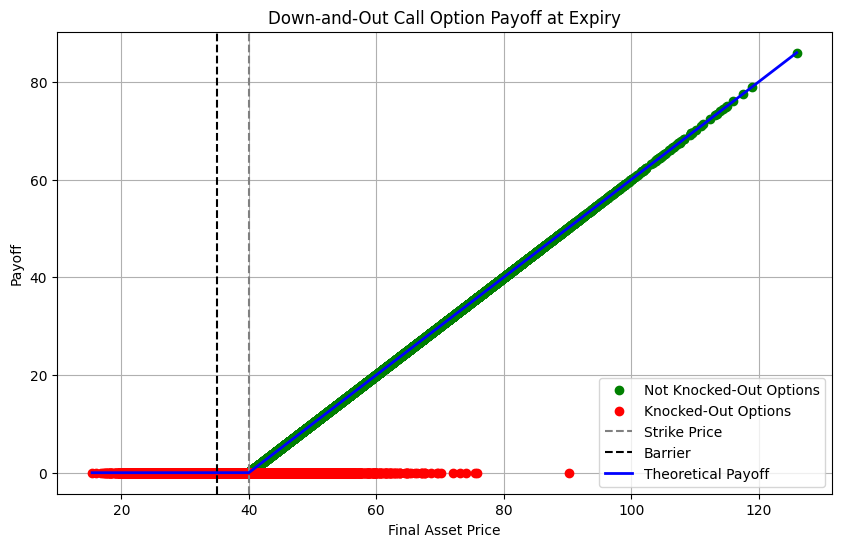

8.276539650182983

In [20]:
down_out_call(S0 = 45,
            T = 1,
            sigma = 0.25,
            r = 0.05,
            N = 252,
            n_sims = 100_000,
            K = 40,
            B = 35)

## Down-and-Out Put Option

### This put option is active unless the price of the underlying asset moves down and touches or falls below the barrier level. If the barrier is crossed, the option knocks out.

In [21]:
def down_out_put(S0: float, 
                 T: float,
                 sigma: float,
                 r: float,
                 N: int,
                 n_sims: int,
                 K: float,
                 B: float):

    paths = random_walk(S0,
                        T,
                        sigma,
                        r,
                        N,
                        n_sims)
    
    barrier = (np.min(paths, axis=0) > B) * 1

    payoffs = np.maximum(K - paths[-1], 0) * barrier

    prob_in_the_money = np.mean((paths[-1] < K) & (np.min(paths, axis=0) > B))
    prob_out_of_the_money = 1 - prob_in_the_money
    prob_knocked_out = 1 - np.mean(np.min(paths, axis=0) > B) 
    prob_not_knocked_out = 1 - prob_knocked_out

    price = np.mean(payoffs) * np.exp(-r * T)

    print(f"Expected Price of the Down-and-Out Put Option: ${price:.4f}")
    print(f"Probability of being in-the-money: {prob_in_the_money*100:.4f}%")
    print(f"Probability of being out-of-the-money: {prob_out_of_the_money*100:.4f}%")
    print(f"Probability of being knocked out: {prob_knocked_out*100:.4f}%")
    print(f"Probability of not being knocked out: {prob_not_knocked_out*100:.4f}%")

    plt.figure(figsize=(10, 6))
    not_knocked_out_options = barrier == 1 
    plt.plot(paths[-1][not_knocked_out_options], payoffs[not_knocked_out_options], 'go', label='Not Knocked-Out Options', markersize=5) 
    knocked_out_options = paths[-1][~not_knocked_out_options]
    plt.plot(knocked_out_options, np.zeros_like(knocked_out_options), 'ro', label='Knocked-Out Options', markersize = 5)  

    final_prices = np.linspace(paths[-1].min(), paths[-1].max(), num=500)
    theoretical_payoffs = np.maximum(K - final_prices, 0) * (final_prices > B)
    plt.plot(final_prices, theoretical_payoffs, 'k-', label='Theoretical Payoff', linewidth=2) 

    plt.axvline(x=K, color='gray', linestyle='--', label='Strike Price') 
    plt.axvline(x=B, color='black', linestyle='--', label='Barrier')  
    plt.xlabel('Final Asset Price')
    plt.ylabel('Payoff')
    plt.title('Down-and-Out Put Option Payoff at Expiry')
    plt.legend()
    plt.grid(True)
    plt.show()

    return price

Expected Price of the Down-and-Out Put Option: $2.1720
Probability of being in-the-money: 36.6350%
Probability of being out-of-the-money: 63.3650%
Probability of being knocked out: 27.3460%
Probability of not being knocked out: 72.6540%


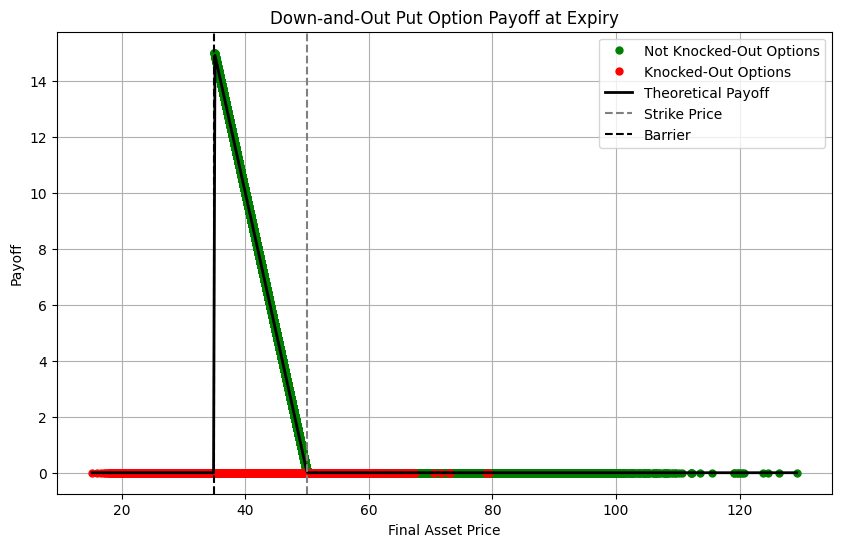

2.1720490944646036

In [22]:
down_out_put(S0 = 45,
            T = 1,
            sigma = 0.25,
            r = 0.05,
            N = 252,
            n_sims = 100_000,
            K = 50,
            B = 35)

## Lookback Options

## Floating Lookback Call

### The strike price is floating, meaning the payoff is determined by the difference between the price of the underlying at expiration and the lowest price of the underlying asset during the life of the option.

### The holder benefits from buying at the lowest observed price and selling at the price at expiration.

In [23]:
def float_lb_call(S0: float, 
                  T: float,
                  sigma: float,
                  r: float,
                  N: int,
                  n_sims: int):

    paths = random_walk(S0,
                        T,
                        sigma,
                        r,
                        N,
                        n_sims)

    mins = np.min(paths, axis=0)  

    payoffs = np.maximum(paths[-1] - mins, 0) 

    prob_in_the_money = np.mean(payoffs > 0)  
    prob_out_of_the_money = 1 - prob_in_the_money  

    price = np.mean(payoffs) * np.exp(-r * T)  

    print(f"Expected Price of the Lookback Call Option: ${price:.4f}")
    print(f"Probability of being in-the-money: {prob_in_the_money*100:.4f}%")
    print(f"Probability of being out-of-the-money: {prob_out_of_the_money*100:.4f}%")

    min_price = np.min(paths[:, 0])  
    sell_price = paths[-1, 0]  

    if sell_price > min_price:
        print(f"Option is exercised.")
        print(f"Buy Price: ${min_price:.4f}")
        print(f"Sell Price: ${sell_price:.4f}")
        print(f"Profit (Sell - Buy): ${sell_price - min_price:.4f}")
    else:
        print(f"Option is not exercised.")
        print(f"No Profit as option is out of the money.")

    plt.figure(figsize=(10, 6))
    plt.plot(paths[:, 0], 'b-', label='Sample Path') 

    min_index = np.argmin(paths[:, 0])
    buy_price = paths[min_index, 0]
    sell_price = paths[-1, 0]

    plt.plot(min_index, buy_price, 'go', label='Buy at Minimum Price') 
    plt.plot(N-1, sell_price, 'ro', label='Sell at Final Price')
    """
    plt.axhline(y=buy_price, color='g', linestyle='--', label='Buy Price')  # Drawing horizontal line at buy price
    plt.axhline(y=sell_price, color='r', linestyle='--', label='Sell Price')  # Drawing horizontal line at sell price
    """
    plt.axhline(y=paths[min_index, 0], color='g', linestyle='--', label='Minimum Price')  

    plt.axhline(y=paths[-1, 0], color='r', linestyle='--', label='Final Price')  

    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    plt.title('Sample Path of a Floating Lookback Call Option with Buy and Sell Points')
    plt.legend()
    plt.grid(True)
    plt.show()

    return price

Expected Price of the Lookback Call Option: $9.8543
Probability of being in-the-money: 96.8250%
Probability of being out-of-the-money: 3.1750%
Option is not exercised.
No Profit as option is out of the money.


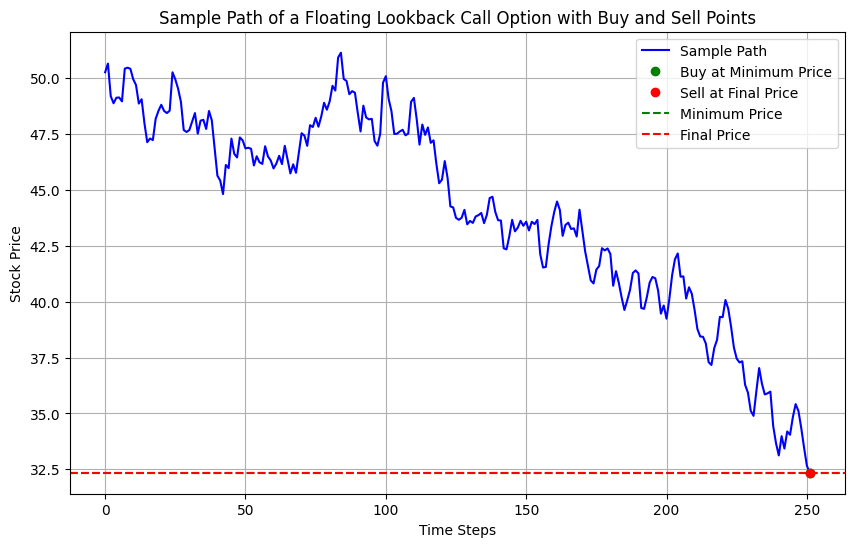

9.854336565566744

In [24]:
float_lb_call(S0 = 50, 
              T = 1,
              sigma = 0.25,
              r = 0.05,
              N = 252,
              n_sims = 100_000)

## Floating Lookback Put

### The strike price is floating, and the payoff is the difference between the maximum price of the underlying asset during the life of the option and the price at expiration.

### The holder benefits from selling at the highest observed price and repurchasing at the price at expiration.

In [25]:
def float_lb_put(S0: float, 
                 T: float,
                 sigma: float,
                 r: float,
                 N: int,
                 n_sims: int):

    paths = random_walk(S0,
                        T,
                        sigma,
                        r,
                        N,
                        n_sims)

    maxs = np.max(paths, axis=0)  

    payoffs = np.maximum(maxs - paths[-1], 0) 

    prob_in_the_money = np.mean(payoffs > 0)  
    prob_out_of_the_money = 1 - prob_in_the_money  

    price = np.mean(payoffs) * np.exp(-r * T)  

    print(f"Expected Price of the Floating Lookback Put Option: ${price:.4f}")
    print(f"Probability of being in-the-money: {prob_in_the_money*100:.4f}%")
    print(f"Probability of being out-of-the-money: {prob_out_of_the_money*100:.4f}%")

    max_price = np.max(paths[:, 0])  
    sell_price = paths[-1, 0]  

    if sell_price < max_price:
        print(f"Option is exercised.")
        print(f"Sell Price: ${max_price:.4f}")
        print(f"Buy Price: ${sell_price:.4f}")
        print(f"Profit (Sell - Buy): ${max_price - sell_price:.4f}")
    else:
        print(f"Option is not exercised.")
        print(f"No Profit as option is out of the money.")

    plt.figure(figsize=(10, 6))
    plt.plot(paths[:, 0], 'b-', label='Sample Path')

    max_index = np.argmax(paths[:, 0])
    max_price = paths[max_index, 0]
    sell_price = paths[-1, 0]

    plt.plot(max_index, max_price, 'go', label='Sell at Maximum Price')
    plt.plot(N-1, sell_price, 'ro', label='Final Price')

    plt.axhline(y=max_price, color='g', linestyle='--', label='Maximum Price')
    plt.axhline(y=sell_price, color='r', linestyle='--', label='Final Buy Price')

    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    plt.title('Sample Path of a Floating Lookback Put Option with Maximum and Final Sell Points')
    plt.legend()
    plt.grid(True)
    plt.show()

    return price

Expected Price of the Floating Lookback Put Option: $8.7732
Probability of being in-the-money: 96.0660%
Probability of being out-of-the-money: 3.9340%
Option is exercised.
Sell Price: $53.3635
Buy Price: $46.0995
Profit (Sell - Buy): $7.2640


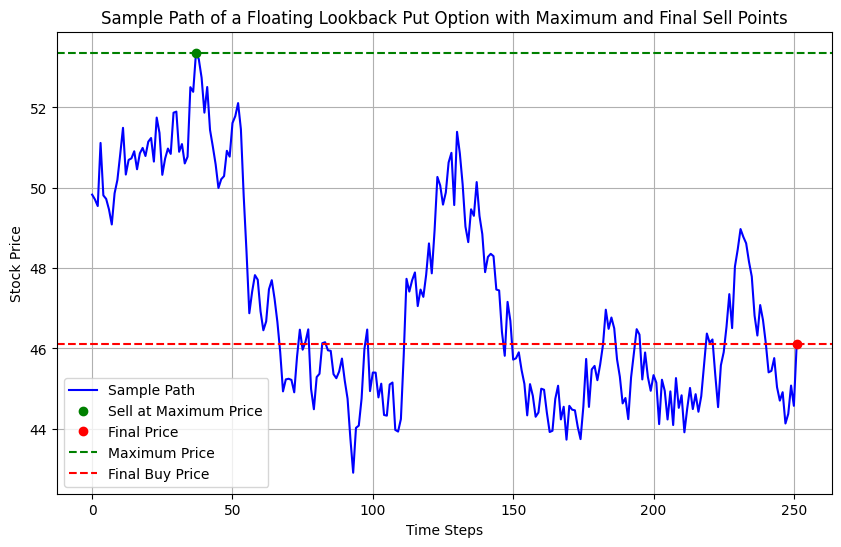

8.773198361622335

In [26]:
float_lb_put(S0 = 50, 
              T = 1,
              sigma = 0.25,
              r = 0.05,
              N = 252,
              n_sims = 100_000)

## Fixed Lookback Call

### The payoff is based on the difference between the maximum price of the underlying asset during the option's life and the strike price.

### Payoff: The holder gets the maximum potential profit by purchasing at the lowest possible price (the strike price) and selling at the highest observed price.

In [27]:
def fixed_lb_call(S0: float, 
                  T: float,
                  sigma: float,
                  r: float,
                  N: int,
                  n_sims: int,
                  K: float):

    paths = random_walk(S0,
                        T,
                        sigma,
                        r,
                        N,
                        n_sims)

    maxs = np.max(paths, axis=0)

    payoffs = np.maximum(maxs - K, 0)

    prob_in_the_money = np.mean(maxs > K)
    prob_out_of_the_money = 1 - prob_in_the_money

    price = np.mean(payoffs) * np.exp(-r * T)

    print(f"Expected Price of the Fixed Lookback Call Option: ${price:.4f}")
    print(f"Probability of being in-the-money: {prob_in_the_money*100:.4f}%")
    print(f"Probability of being out-of-the-money: {prob_out_of_the_money*100:.4f}%")

    max_price = np.max(paths[:, 0])  
    sell_price = paths[-1, 0]  

    if max_price > K:
        print(f"Option is exercised.")
        print(f"Buy Price: ${K:.4f}")
        print(f"Sell Price: ${max_price:.4f}")
        print(f"Profit (Sell - Buy): ${max_price - K:.4f}")
    else:
        print(f"Option is not exercised.")
        print(f"No Profit as option is out of the money.")

    plt.figure(figsize=(10, 6))
    plt.plot(paths[:, 0], 'b-', label='Sample Path')

    max_index = np.argmax(paths[:, 0])
    max_price = paths[max_index, 0]

    plt.plot(max_index, max_price, 'go', label='Sell at Maximum Price')
    plt.axhline(y=K, color='r', linestyle='--', label='Fixed Strike Price')

    plt.axhline(y=max_price, color='g', linestyle='--', label='Maximum Price')

    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    plt.title('Sample Path of a Fixed Lookback Call Option with Maximum and Strike Prices')
    plt.legend()
    plt.grid(True)
    plt.show()

    return price

Expected Price of the Fixed Lookback Call Option: $10.7270
Probability of being in-the-money: 65.5170%
Probability of being out-of-the-money: 34.4830%
Option is not exercised.
No Profit as option is out of the money.


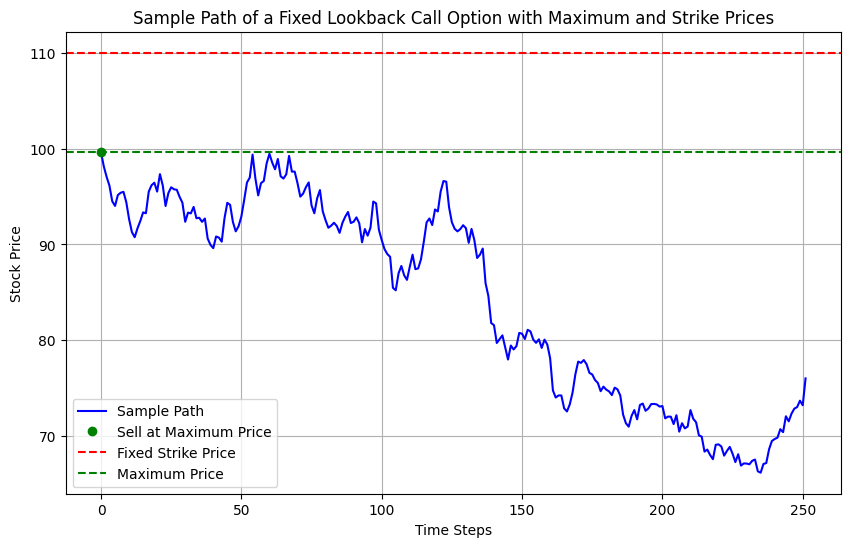

10.726968953179592

In [28]:
fixed_lb_call(S0 = 100, 
              T = 1,
              sigma = 0.2,
              r = 0.05,
              N = 252,
              n_sims = 100_000,
              K = 110)

## Fixed Lookback Put

### The payoff is based on the difference between the strike price and the minimum price of the underlying asset during the option’s life.

### Payoff: The holder gets the maximum potential benefit by selling at the highest price (the strike price) and repurchasing at the lowest observed price.

In [29]:
def fixed_lb_put(S0: float, 
                 T: float,
                 sigma: float,
                 r: float,
                 N: int,
                 n_sims: int,
                 K: float):

    paths = random_walk(S0,
                        T,
                        sigma,
                        r,
                        N,
                        n_sims)

    mins = np.min(paths, axis=0)

    payoffs = np.maximum(K - mins, 0)

    prob_in_the_money = np.mean(K > mins)  
    prob_out_of_the_money = 1 - prob_in_the_money  

    price = np.mean(payoffs) * np.exp(-r * T)  

    print(f"Expected Price of the Fixed Lookback Put Option: ${price:.4f}")
    print(f"Probability of being in-the-money: {prob_in_the_money*100:.4f}%")
    print(f"Probability of being out-of-the-money: {prob_out_of_the_money*100:.4f}%")

    min_price = np.min(paths[:, 0])  
    sell_price = K

    if K > min_price:
        print(f"Option is exercised.")
        print(f"Sell Price: ${sell_price:.4f}")
        print(f"Buy Price: ${min_price:.4f}")
        print(f"Profit (Sell - Buy): ${sell_price - min_price:.4f}")
    else:
        print(f"Option is not exercised.")
        print(f"No Profit as option is out of the money.")

    plt.figure(figsize=(10, 6))
    plt.plot(paths[:, 0], 'b-', label='Sample Path')

    min_index = np.argmin(paths[:, 0])
    plt.plot(min_index, min_price, 'ro', label='Buy at Minimum Price')
    plt.plot(N-1, K, 'go', label='Sell at Strike Price')

    plt.axhline(y=K, color='g', linestyle='--', label='Fixed Strike Price')
    plt.axhline(y=min_price, color='r', linestyle='--', label='Minimum Price')

    plt.xlabel('Time Steps')
    plt.ylabel('Stock Price')
    plt.title('Sample Path of a Fixed Lookback Put Option with Minimum and Strike Prices')
    plt.legend()
    plt.grid(True)
    plt.show()

    return price

Expected Price of the Fixed Lookback Put Option: $11.7901
Probability of being in-the-money: 95.6990%
Probability of being out-of-the-money: 4.3010%
Option is exercised.
Sell Price: $100.0000
Buy Price: $95.7034
Profit (Sell - Buy): $4.2966


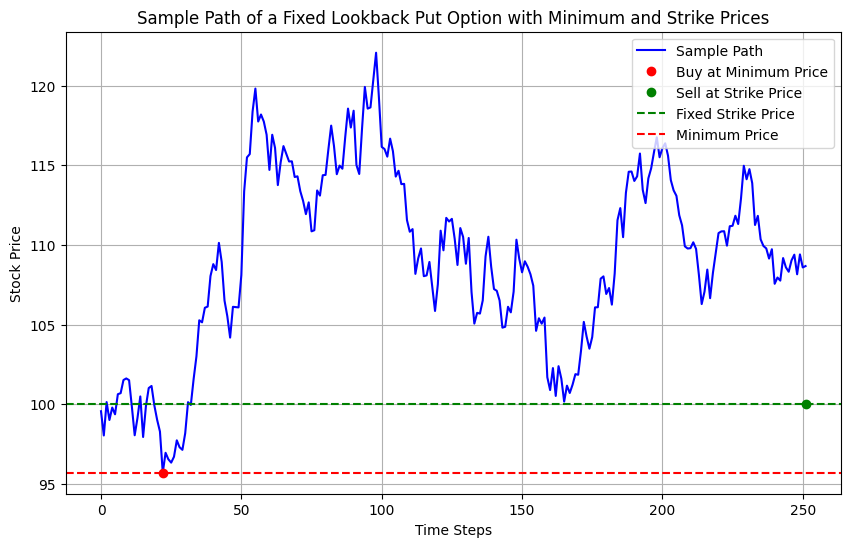

11.790140545982059

In [30]:
fixed_lb_put(S0 = 100, 
              T = 1,
              sigma = 0.2,
              r = 0.05,
              N = 252,
              n_sims = 100_000,
              K = 100)

## Spread Option

### Spread Call Option

In [31]:
def spread_call(S0: list, 
                T: float,
                sigma: list,
                r: float,
                N: int,
                n_sims: int,
                K: float):
    
    paths1 = random_walk(S0[0],
                         T,
                         sigma[0],
                         r,
                         N,
                         n_sims)
    
    paths2 = random_walk(S0[1],
                         T,
                         sigma[1],
                         r,
                         N,
                         n_sims)
    
    spread = paths1 - paths2

    payoffs = np.maximum(spread[-1] - K, 0)

    prob_in_the_money = np.mean(spread[-1] > K)  
    prob_out_of_the_money = 1 - prob_in_the_money  

    price = np.mean(payoffs) * np.exp(-r * T)  

    print(f"Expected Price of the Spread Call Option: ${price:.4f}")
    print(f"Probability of being in-the-money: {prob_in_the_money*100:.4f}%")
    print(f"Probability of being out-of-the-money: {prob_out_of_the_money*100:.4f}%")
    
    plt.figure(figsize=(10, 6))
    plt.hist(spread[-1], bins=100, color='skyblue', edgecolor='k', alpha=0.7)
    plt.axvline(x=K, color='r', linestyle='--', label=f'Strike Price = {K}')
    plt.title('Spread at Expiry')
    plt.xlabel('Spread')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    plt.figure(figsize=(10, 6))
    plt.plot(spread[-1], payoffs, 'bo', markersize=5, label='Payoff at Expiry')
    plt.axvline(x=K, color='r', linestyle='--', label=f'Strike Price = {K}')
    plt.title('Payoff vs Spread at Expiry')
    plt.xlabel('Spread')
    plt.ylabel('Payoff')
    plt.legend()
    plt.grid(True)
    plt.show()

    return price

Expected Price of the Spread Call Option: $4.2052
Probability of being in-the-money: 36.6220%
Probability of being out-of-the-money: 63.3780%


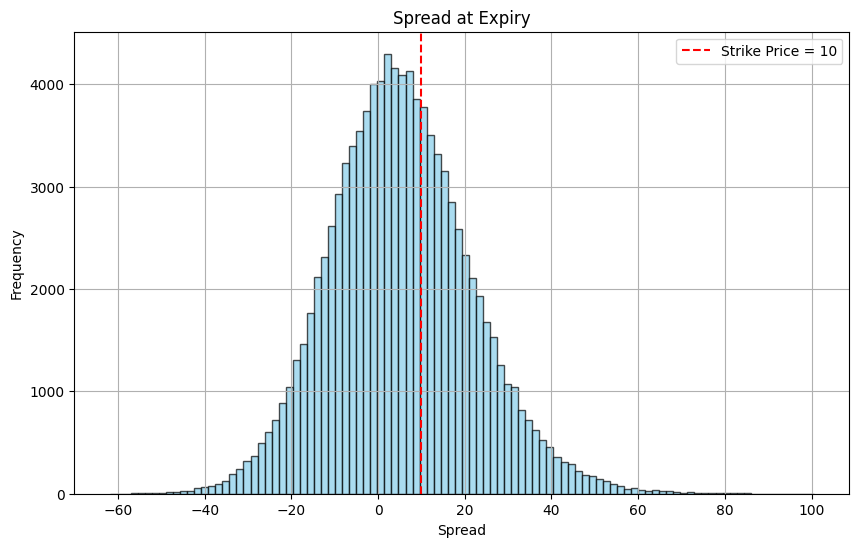

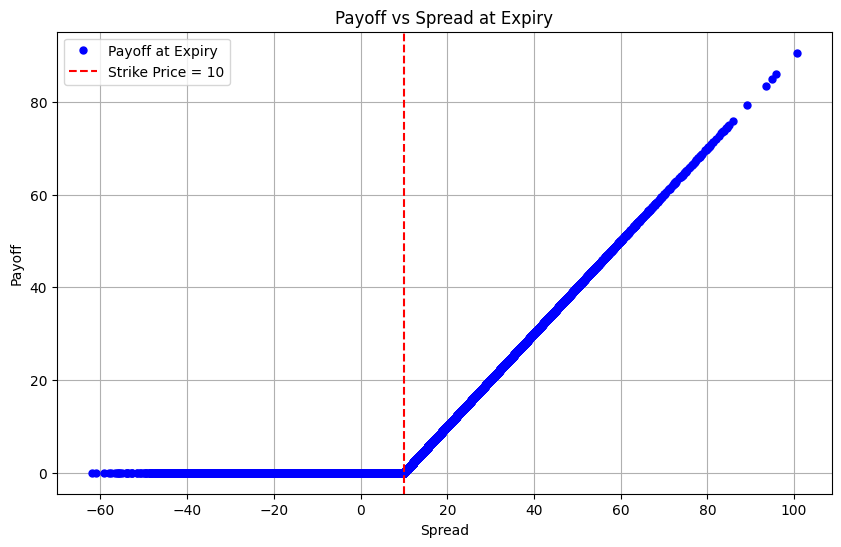

4.205167573175073

In [32]:
spread_call(S0 = [50, 45],
            T = 1,
            sigma = (0.25, 0.2),
            r = 0.05,
            N = 252,
            n_sims = 100_000,
            K = 10)